In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# In this notebook we will build a model around Apple's historical stock price using Long Short-Term Memory (LSTM)

In [77]:
window = 60

In [79]:
# Load in intitial datasets (goes back to 1980)
ticker = 'aapl'
startdate = '2022-01-01'
aapl = pandas_datareader.DataReader(ticker.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
aapl.reset_index(inplace=True)

## Data cleaning

In [1896]:
aapl.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939
1,2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963
2,2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098274
3,2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035
4,2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483612


In [1897]:
# Convert date column to datetime from string so that it can easily be operated on
aapl['Date'] = pd.to_datetime(aapl['Date'])
aapl.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939
1,2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963
2,2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098274
3,2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035
4,2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483612


In [1898]:
# Remove dates before June 29, 2007 (The day the iPhone was introduced and the business changed forever)
# This allows us to only use data where AAPL traded like the company it is today
aapl = aapl[(aapl['Date'] > startdate)]
aapl.set_index('Date', inplace=True)
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098274
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035
2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483612


## View the data we have based on mid price of the day

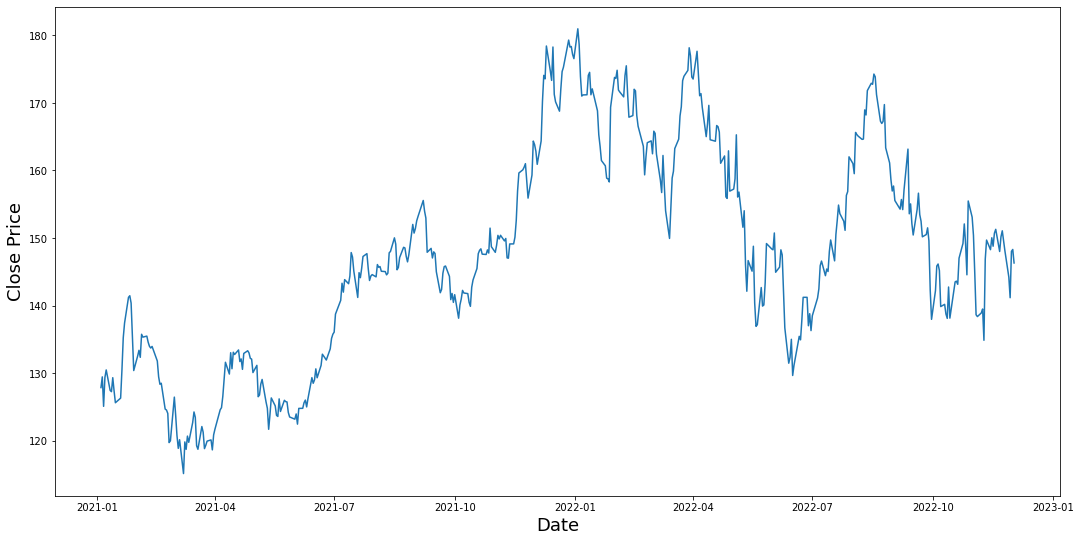

In [1899]:
# Show adjusted close price of apple since 2007 (essentially a stock price chart) 
plt.figure(figsize = (18,9))
plt.plot(aapl['Adj Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

## Now let's normalize our data

In [1900]:
# Create an series of closing prices by accessing the 'Adj Close' column
aapl.reset_index(inplace=True)
close = aapl['Adj Close']
close

0      127.874939
1      129.455963
2      125.098274
3      129.367035
4      130.483612
          ...    
479    144.220001
480    141.169998
481    148.029999
482    148.309998
483    146.309998
Name: Adj Close, Length: 484, dtype: float64

In [1901]:
aapl

,Date,High,Low,Open,Close,Volume,Adj Close
0,2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939
1,2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963
2,2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098274
3,2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035
4,2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483612
...,...,...,...,...,...,...,...
479,2022-11-28,146.639999,143.380005,145.139999,144.220001,69246000.0,144.220001
480,2022-11-29,144.809998,140.350006,144.289993,141.169998,83763800.0,141.169998
481,2022-11-30,148.720001,140.550003,141.399994,148.029999,111380900.0,148.029999
482,2022-12-01,149.130005,146.610001,148.210007,148.309998,71176600.0,148.309998


In [1902]:
# Normalize data 
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) # We will normalize between 0 and 1
close_array = np.array(close)
close_array = close_array.reshape(-1, 1) # Reshape the array so that each element is its own row
close_scaled = scaler.fit_transform(close_array) # Perform normalization
close_scaled

array([[0.19334044],
       [0.21736517],
       [0.15114712],
       [0.21601385],
       [0.232981  ],
       [0.18688385],
       [0.18418131],
       [0.21556333],
       [0.18583302],
       [0.15925565],
       [0.16961608],
       [0.23268096],
       [0.30535548],
       [0.33838944],
       [0.39619892],
       [0.39980261],
       [0.38328528],
       [0.3086589 ],
       [0.23162991],
       [0.26436359],
       [0.27712652],
       [0.26136021],
       [0.31316386],
       [0.30677243],
       [0.30902804],
       [0.29549392],
       [0.28617052],
       [0.282261  ],
       [0.28586979],
       [0.25308741],
       [0.21774822],
       [0.20075556],
       [0.20316166],
       [0.14496495],
       [0.14285983],
       [0.13519034],
       [0.06962523],
       [0.07368546],
       [0.17188282],
       [0.13173168],
       [0.08571603],
       [0.05669281],
       [0.07609167],
       [0.        ],
       [0.07112912],
       [0.0544372 ],
       [0.08421214],
       [0.070

## Below we select train and test data and perform reshaping

In [1903]:
# Train test split
X_train = []
y_train = []
X_test = []
y_test = []

# Select how much data we want to train / test on (75% for LSTM is appropriate)
# Important to note that train and test sets must be near each other since this is time-series data
training_size = round(len(close_scaled) * 0.75)
training_data = close_scaled[:training_size]
test_data = close_scaled[training_size:]

for i in range(window, len(training_data)):
    # Training will use the trailing window days (can tweak this parameter)
    X_train.append(close_scaled[i-window:i, 0]) # Indexing of 0 to get the actual elements that are in an array by themselves
    # Test uses the day following the previous window days 
    y_train.append(close_scaled[i, 0])

for i in range(len(training_data)+window, len(close_scaled)):
    # Testing will use the trailing window days (can tweak this parameter)
    X_test.append(close_scaled[i-window:i, 0])
    y_test.append(close_scaled[i, 0])

X_test

[array([0.24810596, 0.26143742, 0.30188651, 0.22053388, 0.24325807,
        0.30855247, 0.30067477, 0.34491118, 0.39626779, 0.39626779,
        0.33233723, 0.35945462, 0.32142948, 0.35490955, 0.39475276,
        0.4153563 , 0.467319  , 0.47777183, 0.4448974 , 0.45989553,
        0.45429036, 0.49943569, 0.52518993, 0.47822652, 0.53776388,
        0.56866883, 0.60366416, 0.58457565, 0.56730545, 0.54685379]),
 array([0.26143742, 0.30188651, 0.22053388, 0.24325807, 0.30855247,
        0.30067477, 0.34491118, 0.39626779, 0.39626779, 0.33233723,
        0.35945462, 0.32142948, 0.35490955, 0.39475276, 0.4153563 ,
        0.467319  , 0.47777183, 0.4448974 , 0.45989553, 0.45429036,
        0.49943569, 0.52518993, 0.47822652, 0.53776388, 0.56866883,
        0.60366416, 0.58457565, 0.56730545, 0.54685379, 0.6254792 ]),
 array([0.30188651, 0.22053388, 0.24325807, 0.30855247, 0.30067477,
        0.34491118, 0.39626779, 0.39626779, 0.33233723, 0.35945462,
        0.32142948, 0.35490955, 0.39475276, 

In [1904]:
# Convert each dataset to numpy arrays again
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [1905]:
X_test

array([[0.24810596, 0.26143742, 0.30188651, ..., 0.58457565, 0.56730545,
        0.54685379],
       [0.26143742, 0.30188651, 0.22053388, ..., 0.56730545, 0.54685379,
        0.6254792 ],
       [0.30188651, 0.22053388, 0.24325807, ..., 0.54685379, 0.6254792 ,
        0.63396324],
       ...,
       [0.43095519, 0.43262395, 0.42549378, ..., 0.50082597, 0.44171478,
        0.39536791],
       [0.43262395, 0.42549378, 0.48435548, ..., 0.44171478, 0.39536791,
        0.49961029],
       [0.42549378, 0.48435548, 0.517427  , ..., 0.39536791, 0.49961029,
        0.50386506]])

In [1906]:
y_train

array([0.21774822, 0.20075556, 0.20316166, 0.14496495, 0.14285983,
       0.13519034, 0.06962523, 0.07368546, 0.17188282, 0.13173168,
       0.08571603, 0.05669281, 0.07609167, 0.        , 0.07112912,
       0.0544372 , 0.08421214, 0.07022681, 0.11473891, 0.13849874,
       0.12631815, 0.06270792, 0.05458733, 0.10571636, 0.09293408,
       0.05609111, 0.06361   , 0.07293363, 0.07564057, 0.05323415,
       0.08706933, 0.09985138, 0.14346129, 0.14812299, 0.17353696,
       0.21053041, 0.25022987, 0.22376356, 0.27173397, 0.2356433 ,
       0.27278688, 0.2676742 , 0.2778998 , 0.25188424, 0.25774887,
       0.23429012, 0.27008006, 0.27609517, 0.27113297, 0.25895227,
       0.25744814, 0.22707208, 0.24331256, 0.17278502, 0.17654464,
       0.20120701, 0.21160025, 0.16098736, 0.14682778, 0.09952862,
       0.1326682 , 0.17002544, 0.15225035, 0.13086056, 0.12845052,
       0.16791661, 0.13959733, 0.16475324, 0.16174058, 0.16098736,
       0.13733778, 0.12724539, 0.1222745 , 0.13402381, 0.11112

In [1907]:
X_train.shape

(333, 30)

In [1908]:
# Reshape into 3D arrays 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [1909]:
# 2850 groups, each of length 60, where each element is its own row within the group
X_train.shape

(333, 30, 1)

In [1910]:
X_test

array([[[0.24810596],
        [0.26143742],
        [0.30188651],
        ...,
        [0.58457565],
        [0.56730545],
        [0.54685379]],

       [[0.26143742],
        [0.30188651],
        [0.22053388],
        ...,
        [0.56730545],
        [0.54685379],
        [0.6254792 ]],

       [[0.30188651],
        [0.22053388],
        [0.24325807],
        ...,
        [0.54685379],
        [0.6254792 ],
        [0.63396324]],

       ...,

       [[0.43095519],
        [0.43262395],
        [0.42549378],
        ...,
        [0.50082597],
        [0.44171478],
        [0.39536791]],

       [[0.43262395],
        [0.42549378],
        [0.48435548],
        ...,
        [0.44171478],
        [0.39536791],
        [0.49961029]],

       [[0.42549378],
        [0.48435548],
        [0.517427  ],
        ...,
        [0.39536791],
        [0.49961029],
        [0.50386506]]])

In [1911]:
# Keras is a NN library built on top of Tensorflow that has LSTM built-in
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
print(X_train.shape)
print(y_train.shape)

(333, 30, 1)
(333,)


In [1912]:
X_train.shape[1]

30

In [1913]:
X_train.shape[2]

1

## Create LSTM model

In [1914]:
# Create the LSTM model with multiple dropout layers to prevent overfitting
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# Use a dropout of 20 to prevent overfitting (this will allow us to use our model for other stocks)
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 30, 50)            10400     
                                                                 
 dropout_64 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_72 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_65 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_73 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_66 (Dropout)        (None, 50)                0         
                                                                 
 dense_30 (Dense)            (None, 1)               

In [1915]:
# Train the model on our training data
# 64 is a standard batch size, while 100 epochs is usually efficient. 
# Verbose just allows us to view the status of training as it happens
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
11/11 [==============================] - 5s 26ms/step - loss: 0.1431
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0264
Epoch 3/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0219
Epoch 4/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0181
Epoch 5/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0143
Epoch 6/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0148
Epoch 7/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0143
Epoch 8/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0149
Epoch 9/100
11/11 [==============================] - 0s 24ms/step - loss: 0.0139
Epoch 10/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0139
Epoch 11/100
11/11 [==============================] - 0s 24ms/step - loss: 0.0129
Epoch 12/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0121
Epoch 13/100
11/11 [=====

In [1916]:
model.save('../models/LSTMmodelrecent_' + str(window))

INFO:tensorflow:Assets written to: ../models/LSTMmodelrecent_30\assets


INFO:tensorflow:Assets written to: ../models/LSTMmodelrecent_30\assets


In [7]:
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [1918]:
X_test

array([[[0.24810596],
        [0.26143742],
        [0.30188651],
        ...,
        [0.58457565],
        [0.56730545],
        [0.54685379]],

       [[0.26143742],
        [0.30188651],
        [0.22053388],
        ...,
        [0.56730545],
        [0.54685379],
        [0.6254792 ]],

       [[0.30188651],
        [0.22053388],
        [0.24325807],
        ...,
        [0.54685379],
        [0.6254792 ],
        [0.63396324]],

       ...,

       [[0.43095519],
        [0.43262395],
        [0.42549378],
        ...,
        [0.50082597],
        [0.44171478],
        [0.39536791]],

       [[0.43262395],
        [0.42549378],
        [0.48435548],
        ...,
        [0.44171478],
        [0.39536791],
        [0.49961029]],

       [[0.42549378],
        [0.48435548],
        [0.517427  ],
        ...,
        [0.39536791],
        [0.49961029],
        [0.50386506]]])

In [1919]:
# Perform predictions
predicted_price = model.predict(X_test)

3/3 [==============================] - 1s 8ms/step


In [1920]:
predicted_price

array([[0.57548785],
       [0.576232  ],
       [0.5885869 ],
       [0.6237174 ],
       [0.6613837 ],
       [0.6813381 ],
       [0.70570946],
       [0.7278036 ],
       [0.74072295],
       [0.7420896 ],
       [0.7367545 ],
       [0.74678534],
       [0.76258403],
       [0.79043216],
       [0.82156134],
       [0.84274924],
       [0.8566654 ],
       [0.86084193],
       [0.8474776 ],
       [0.81277454],
       [0.77624977],
       [0.75299984],
       [0.7558718 ],
       [0.74903864],
       [0.72617334],
       [0.69124424],
       [0.65384924],
       [0.6286336 ],
       [0.61158884],
       [0.5986441 ],
       [0.59537494],
       [0.59426844],
       [0.60347366],
       [0.63942057],
       [0.649322  ],
       [0.63921773],
       [0.61104196],
       [0.57459354],
       [0.55527145],
       [0.56286097],
       [0.5758801 ],
       [0.5816829 ],
       [0.57198846],
       [0.5554871 ],
       [0.5433582 ],
       [0.5323918 ],
       [0.5015437 ],
       [0.450

In [1921]:
y_test

array([0.6254792 , 0.63396324, 0.71213418, 0.69698487, 0.67426045,
       0.76697553, 0.76212764, 0.75863849, 0.75135645, 0.75211489,
       0.81765183, 0.80627385, 0.86103938, 0.87757525, 0.87514783,
       0.89820707, 0.89213886, 0.85224046, 0.79231704, 0.78715891,
       0.79171001, 0.82963638, 0.73239316, 0.69841156, 0.66094035,
       0.63530204, 0.64652838, 0.61391155, 0.59449333, 0.61618733,
       0.59343161, 0.63757759, 0.72951081, 0.58402566, 0.60632623,
       0.56172486, 0.5363903 , 0.59373466, 0.63044743, 0.58220527,
       0.56733814, 0.53229413, 0.53745225, 0.55247102, 0.52334357,
       0.41168861, 0.3467587 , 0.41123346, 0.46660601, 0.47115688,
       0.45644163, 0.375431  , 0.38043725, 0.35859184, 0.34888261,
       0.41942581, 0.34948964, 0.41062689, 0.43095519, 0.43262395,
       0.42549378, 0.48435548, 0.517427  , 0.56126993, 0.51591012,
       0.44688427, 0.61284983, 0.57644034, 0.53563163, 0.45037342,
       0.35707496, 0.35297206, 0.36117763, 0.36999115, 0.29963

In [1922]:
# Calculate root mean squared error for expected y values and the predictions from the model
math.sqrt(mean_squared_error(y_test, predicted_price))

0.06705241936403396

In [1923]:
# Transform predicted normalized values back to prices in dollars
predicted_price = scaler.inverse_transform(predicted_price)
predicted_price

array([[153.02338],
       [153.07234],
       [153.88539],
       [156.19727],
       [158.67601],
       [159.98918],
       [161.59302],
       [163.04698],
       [163.89719],
       [163.98712],
       [163.63603],
       [164.29613],
       [165.33583],
       [167.16846],
       [169.21701],
       [170.61134],
       [171.52715],
       [171.80199],
       [170.9225 ],
       [168.63876],
       [166.23514],
       [164.70511],
       [164.8941 ],
       [164.44441],
       [162.9397 ],
       [160.64108],
       [158.18018],
       [156.52078],
       [155.39911],
       [154.54724],
       [154.33209],
       [154.25928],
       [154.86507],
       [157.23067],
       [157.88225],
       [157.21732],
       [155.36311],
       [152.96452],
       [151.69296],
       [152.19241],
       [153.04918],
       [153.43106],
       [152.79308],
       [151.70714],
       [150.90897],
       [150.1873 ],
       [148.15723],
       [144.7952 ],
       [142.0377 ],
       [141.19159],


In [1924]:
# Create prediction df where the date is matched up with the predicted closing price for test data
prediction_df = pd.DataFrame(predicted_price, columns=['Close'])
prediction_df['Date'] = aapl.iloc[training_size+window:]['Date'].values
prediction_df['Date'] = pd.to_datetime(prediction_df['Date'])
prediction_df.head()

,Close,Date
0,153.023376,2022-07-27
1,153.072342,2022-07-28
2,153.885391,2022-07-29
3,156.197266,2022-08-01
4,158.676010,2022-08-02


In [1925]:
# Create new dataframe with the Date as the index (so that dates appear on x-axis of plots)
aapl_dateind = aapl
aapl_dateind['Date'] = pd.to_datetime(aapl_dateind['Date'])
aapl_dateind = aapl_dateind.set_index('Date')
aapl_dateind

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098274
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035
2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483612
...,...,...,...,...,...,...
2022-11-28,146.639999,143.380005,145.139999,144.220001,69246000.0,144.220001
2022-11-29,144.809998,140.350006,144.289993,141.169998,83763800.0,141.169998
2022-11-30,148.720001,140.550003,141.399994,148.029999,111380900.0,148.029999


In [1926]:
# Set index of prediction dataframe to the Date so that it can be plotted with the entire dataset
prediction = prediction_df.set_index(['Date'])
prediction

,Close
Date,
2022-07-27,153.023376
2022-07-28,153.072342
2022-07-29,153.885391
2022-08-01,156.197266
2022-08-02,158.676010
...,...
2022-11-28,148.946533
2022-11-29,147.652679
2022-11-30,145.422867


## Below we plot our prediction for the test data

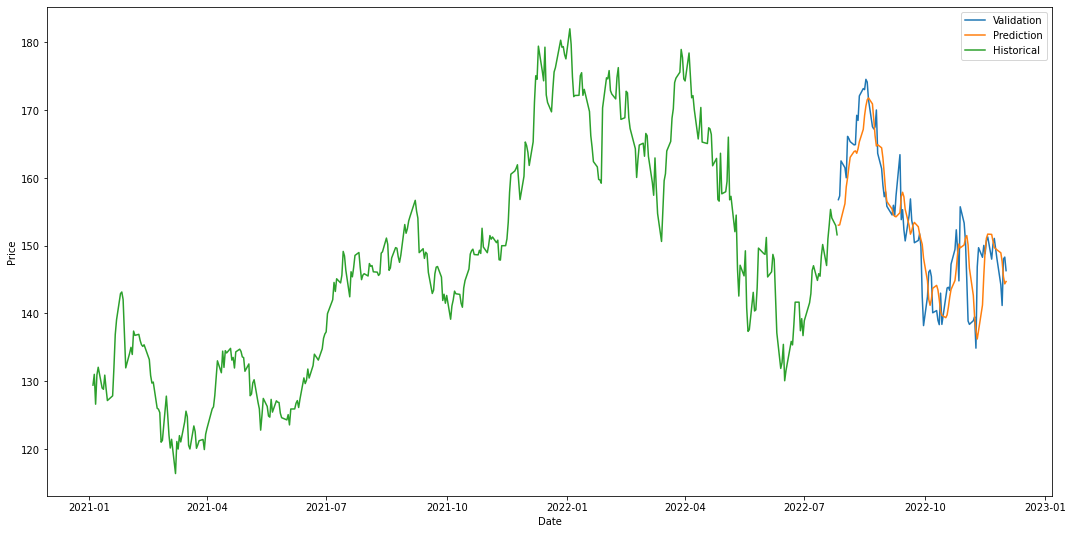

In [1927]:


# Create the plot for model's predictions on the test data 
plt.figure(figsize=(18,9))
# Plot the actual price of the test data
plt.plot(aapl_dateind[training_size+window:len(close_scaled)]['Close'], label='Validation')
# Plot the prediction on test data
plt.plot(prediction['Close'], label='Prediction')
plt.plot(aapl_dateind[:training_size+window]['Close'], label='Historical')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

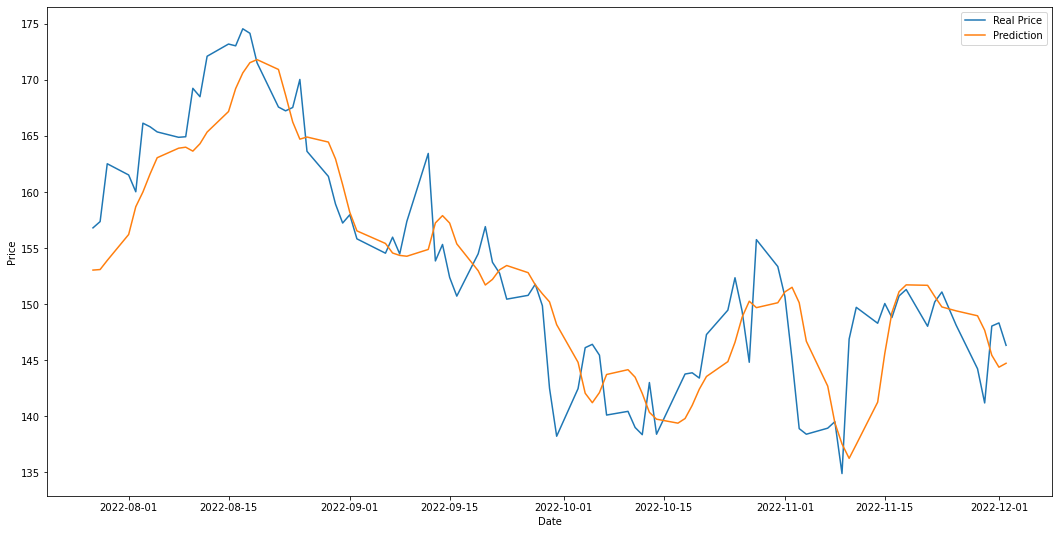

In [1928]:

# Create the plot for model's predictions on the test data 
plt.figure(figsize=(18,9))
# Plot the actual price of the test data
plt.plot(aapl_dateind[training_size+window:len(close_scaled)]['Close'], label='Real Price')
# Plot the prediction on test data
plt.plot(prediction['Close'], label='Prediction')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

## Let's forecast

In [220]:
# Number of days ahead we want to forecast
forecast_days = 5

In [81]:
#model = tf.keras.models.load_model('../models/LSTMonelayer')
model = tf.keras.models.load_model('../models/LSTMmodelrecent_' + str(window))

In [221]:
window

60

In [222]:
import pandas_datareader
from datetime import date

In [223]:
ticker = 'cvx'
startdate = startdate

### Load in data and create train/test sets like before

In [224]:
df = pandas_datareader.DataReader(ticker.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
df.reset_index(inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] > pd.to_datetime(startdate))]




closedata = df.reset_index()['Adj Close']
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(np.array(closedata).reshape(-1,1))
training_size = round(len(close_scaled) * 0.75)
training_data = close_scaled[:training_size]
test_data = close_scaled[training_size:]
X_train = []
y_train = []
X_test = []
y_test = []

In [225]:
close_scaled

array([[0.        ],
       [0.02929724],
       [0.03996299],
       [0.05400424],
       [0.07790095],
       [0.07898112],
       [0.11759405],
       [0.10895333],
       [0.10179787],
       [0.13096012],
       [0.13663053],
       [0.13028514],
       [0.12407443],
       [0.10328292],
       [0.1069282 ],
       [0.1799687 ],
       [0.18131897],
       [0.21750136],
       [0.15323657],
       [0.16295757],
       [0.20967082],
       [0.21804177],
       [0.20170561],
       [0.22438747],
       [0.26043476],
       [0.2319476 ],
       [0.25017389],
       [0.22654717],
       [0.26394505],
       [0.235053  ],
       [0.2215465 ],
       [0.22209246],
       [0.21267891],
       [0.21008658],
       [0.19617093],
       [0.23914574],
       [0.22959581],
       [0.3050406 ],
       [0.35442728],
       [0.43246375],
       [0.49276504],
       [0.52114207],
       [0.55429376],
       [0.6005428 ],
       [0.71637007],
       [0.65825197],
       [0.72032664],
       [0.721

In [226]:
len(close_scaled)

232

In [227]:
len(training_data)

174

In [228]:
''' for i in range(window, len(training_data)):
    # Training will use the trailing 'window' days (can tweak this parameter)
    X_train.append(close_scaled[i-window:i, 0])
    y_train.append(close_scaled[i, 0])
'''
for i in range(window, len(close_scaled)):
    # Testing will use the trailing 'window' days (can tweak this parameter)
    X_test.append(close_scaled[i-window:i, 0])
    y_test.append(close_scaled[i, 0])


In [229]:
X_test

[array([0.        , 0.02929724, 0.03996299, 0.05400424, 0.07790095,
        0.07898112, 0.11759405, 0.10895333, 0.10179787, 0.13096012,
        0.13663053, 0.13028514, 0.12407443, 0.10328292, 0.1069282 ,
        0.1799687 , 0.18131897, 0.21750136, 0.15323657, 0.16295757,
        0.20967082, 0.21804177, 0.20170561, 0.22438747, 0.26043476,
        0.2319476 , 0.25017389, 0.22654717, 0.26394505, 0.235053  ,
        0.2215465 , 0.22209246, 0.21267891, 0.21008658, 0.19617093,
        0.23914574, 0.22959581, 0.3050406 , 0.35442728, 0.43246375,
        0.49276504, 0.52114207, 0.55429376, 0.6005428 , 0.71637007,
        0.65825197, 0.72032664, 0.72141791, 0.66439107, 0.54924613,
        0.5414698 , 0.57871444, 0.59631368, 0.63601425, 0.62851047,
        0.65265839, 0.65866133, 0.69972593, 0.65934345, 0.63164875]),
 array([0.02929724, 0.03996299, 0.05400424, 0.07790095, 0.07898112,
        0.11759405, 0.10895333, 0.10179787, 0.13096012, 0.13663053,
        0.13028514, 0.12407443, 0.10328292, 0.

In [231]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [232]:
len(X_test)

172

6/6 [==============================] - 0s 14ms/step


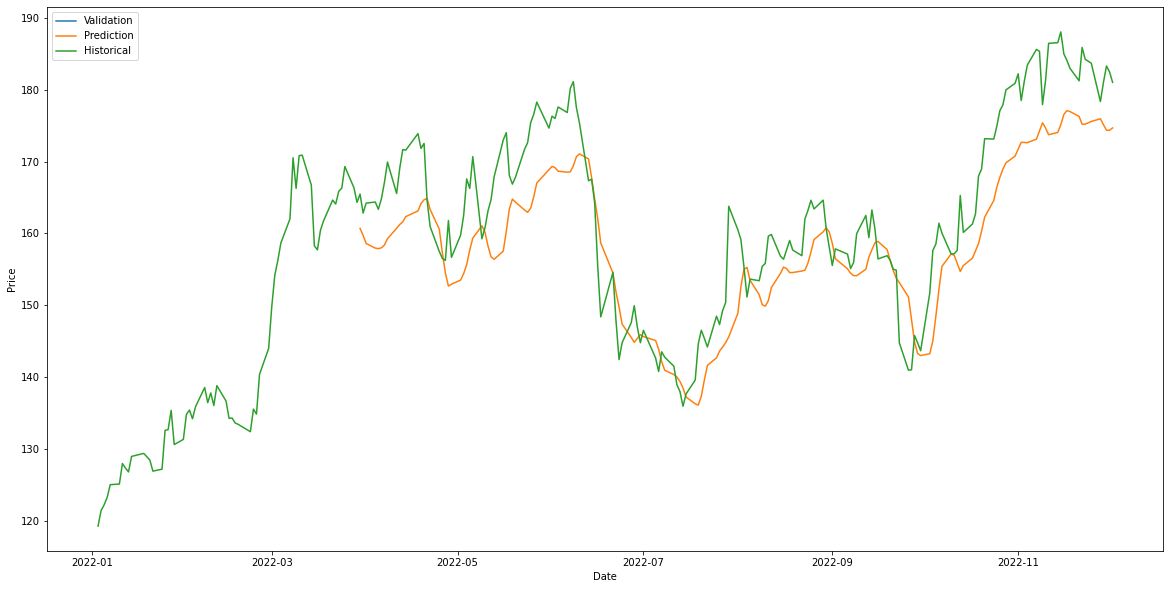

In [233]:
prediction = model.predict(X_test)
mse = math.sqrt(mean_squared_error(y_test, prediction))
predicted_price = scaler.inverse_transform(prediction)

# Create prediction df where the date is matched up with the predicted closing price for test data
prediction_df = pd.DataFrame(predicted_price, columns=['Close'])
prediction_df['Date'] = df.iloc[window:]['Date'].values
prediction_df['Date'] = pd.to_datetime(prediction_df['Date'])

stock_dateind = df.copy()
stock_dateind['Date'] = pd.to_datetime(stock_dateind['Date'])
stock_dateind = stock_dateind.set_index('Date')

prediction_dateind = prediction_df.set_index(['Date'])

# Create the plot for model's predictions on the test data 
visualize = plt.figure(figsize=(20,10))
# Plot the actual price of the test data
plt.plot(stock_dateind[training_size+window-1:len(close_scaled)]['Close'], label='Validation')
# Plot the prediction on test data
plt.plot(prediction_dateind['Close'], label='Prediction')
# Plot the historicals 
plt.plot(stock_dateind[:training_size+window]['Close'], label='Historical')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

## Use final window of data and turn it into data we can use to forecast

In [234]:
len(close_scaled)

232

In [235]:
close_scaled

array([[0.        ],
       [0.02929724],
       [0.03996299],
       [0.05400424],
       [0.07790095],
       [0.07898112],
       [0.11759405],
       [0.10895333],
       [0.10179787],
       [0.13096012],
       [0.13663053],
       [0.13028514],
       [0.12407443],
       [0.10328292],
       [0.1069282 ],
       [0.1799687 ],
       [0.18131897],
       [0.21750136],
       [0.15323657],
       [0.16295757],
       [0.20967082],
       [0.21804177],
       [0.20170561],
       [0.22438747],
       [0.26043476],
       [0.2319476 ],
       [0.25017389],
       [0.22654717],
       [0.26394505],
       [0.235053  ],
       [0.2215465 ],
       [0.22209246],
       [0.21267891],
       [0.21008658],
       [0.19617093],
       [0.23914574],
       [0.22959581],
       [0.3050406 ],
       [0.35442728],
       [0.43246375],
       [0.49276504],
       [0.52114207],
       [0.55429376],
       [0.6005428 ],
       [0.71637007],
       [0.65825197],
       [0.72032664],
       [0.721

In [236]:
X_test[-1]

array([[0.55445212],
       [0.61024981],
       [0.64536612],
       [0.6024769 ],
       [0.65605385],
       [0.61927172],
       [0.56139202],
       [0.56763805],
       [0.55903255],
       [0.54140492],
       [0.53973931],
       [0.39927387],
       [0.34639121],
       [0.34722401],
       [0.4132926 ],
       [0.39927387],
       [0.38400593],
       [0.49587856],
       [0.57777065],
       [0.5902625 ],
       [0.63037564],
       [0.61108262],
       [0.57096927],
       [0.57138567],
       [0.57790938],
       [0.68395238],
       [0.61260928],
       [0.62884897],
       [0.64841967],
       [0.72170604],
       [0.73503091],
       [0.79374321],
       [0.7929104 ],
       [0.81789433],
       [0.84787508],
       [0.85911794],
       [0.88798843],
       [0.90075795],
       [0.91907965],
       [0.86744599],
       [0.90395044],
       [0.93573553],
       [0.96613269],
       [0.96238507],
       [0.85953434],
       [0.90630991],
       [0.97793089],
       [0.979

In [237]:
close_scaled[-60:]

array([[0.61024981],
       [0.64536612],
       [0.6024769 ],
       [0.65605385],
       [0.61927172],
       [0.56139202],
       [0.56763805],
       [0.55903255],
       [0.54140492],
       [0.53973931],
       [0.39927387],
       [0.34639121],
       [0.34722401],
       [0.4132926 ],
       [0.39927387],
       [0.38400593],
       [0.49587856],
       [0.57777065],
       [0.5902625 ],
       [0.63037564],
       [0.61108262],
       [0.57096927],
       [0.57138567],
       [0.57790938],
       [0.68395238],
       [0.61260928],
       [0.62884897],
       [0.64841967],
       [0.72170604],
       [0.73503091],
       [0.79374321],
       [0.7929104 ],
       [0.81789433],
       [0.84787508],
       [0.85911794],
       [0.88798843],
       [0.90075795],
       [0.91907965],
       [0.86744599],
       [0.90395044],
       [0.93573553],
       [0.96613269],
       [0.96238507],
       [0.85953434],
       [0.90630991],
       [0.97793089],
       [0.97917989],
       [1.   

### Reshape data so we can test on it 

In [238]:
start_forecast = X_test[-1]
start_forecast.shape

(60, 1)

In [239]:
start_forecast

array([[0.55445212],
       [0.61024981],
       [0.64536612],
       [0.6024769 ],
       [0.65605385],
       [0.61927172],
       [0.56139202],
       [0.56763805],
       [0.55903255],
       [0.54140492],
       [0.53973931],
       [0.39927387],
       [0.34639121],
       [0.34722401],
       [0.4132926 ],
       [0.39927387],
       [0.38400593],
       [0.49587856],
       [0.57777065],
       [0.5902625 ],
       [0.63037564],
       [0.61108262],
       [0.57096927],
       [0.57138567],
       [0.57790938],
       [0.68395238],
       [0.61260928],
       [0.62884897],
       [0.64841967],
       [0.72170604],
       [0.73503091],
       [0.79374321],
       [0.7929104 ],
       [0.81789433],
       [0.84787508],
       [0.85911794],
       [0.88798843],
       [0.90075795],
       [0.91907965],
       [0.86744599],
       [0.90395044],
       [0.93573553],
       [0.96613269],
       [0.96238507],
       [0.85953434],
       [0.90630991],
       [0.97793089],
       [0.979

In [240]:
start_forecast = np.reshape(start_forecast, (start_forecast.shape[0], start_forecast.shape[1], 1))
start_forecast.shape

(60, 1, 1)

In [241]:
# Reshape so that data looks like X_test input from earlier cells 
start_forecast = start_forecast.reshape(1, window, 1)
start_forecast.shape

(1, 60, 1)

In [242]:
model.predict(start_forecast)

1/1 [==============================] - 0s 20ms/step


array([[0.83319336]], dtype=float32)

In [243]:
forecast_days

5

In [244]:
len(start_forecast)

1

In [245]:
start_forecast

array([[[0.55445212],
        [0.61024981],
        [0.64536612],
        [0.6024769 ],
        [0.65605385],
        [0.61927172],
        [0.56139202],
        [0.56763805],
        [0.55903255],
        [0.54140492],
        [0.53973931],
        [0.39927387],
        [0.34639121],
        [0.34722401],
        [0.4132926 ],
        [0.39927387],
        [0.38400593],
        [0.49587856],
        [0.57777065],
        [0.5902625 ],
        [0.63037564],
        [0.61108262],
        [0.57096927],
        [0.57138567],
        [0.57790938],
        [0.68395238],
        [0.61260928],
        [0.62884897],
        [0.64841967],
        [0.72170604],
        [0.73503091],
        [0.79374321],
        [0.7929104 ],
        [0.81789433],
        [0.84787508],
        [0.85911794],
        [0.88798843],
        [0.90075795],
        [0.91907965],
        [0.86744599],
        [0.90395044],
        [0.93573553],
        [0.96613269],
        [0.96238507],
        [0.85953434],
        [0

In [246]:
forecast_list = start_forecast
for i in range(forecast_days):
    x = forecast_list[-window:] # Get the most recent "window" days (need this many for a prediction)
    x = x.reshape(1, window, 1) # Reshape so model can interpret
    out = model.predict(x)[0][0] # Get the value of the next day that is predicted
    forecast_list = np.append(forecast_list, out) # Append the next day of prediction 

1/1 [==============================] - 0s 17ms/step


In [247]:
forecast_list

array([0.55445212, 0.61024981, 0.64536612, 0.6024769 , 0.65605385,
       0.61927172, 0.56139202, 0.56763805, 0.55903255, 0.54140492,
       0.53973931, 0.39927387, 0.34639121, 0.34722401, 0.4132926 ,
       0.39927387, 0.38400593, 0.49587856, 0.57777065, 0.5902625 ,
       0.63037564, 0.61108262, 0.57096927, 0.57138567, 0.57790938,
       0.68395238, 0.61260928, 0.62884897, 0.64841967, 0.72170604,
       0.73503091, 0.79374321, 0.7929104 , 0.81789433, 0.84787508,
       0.85911794, 0.88798843, 0.90075795, 0.91907965, 0.86744599,
       0.90395044, 0.93573553, 0.96613269, 0.96238507, 0.85953434,
       0.90630991, 0.97793089, 0.97917989, 1.        , 0.95752718,
       0.96480045, 0.94941449, 0.92493661, 0.98997775, 0.96689869,
       0.95934539, 0.88465294, 0.92199917, 0.95389033, 0.94242081,
       0.83319336, 0.81720793, 0.7906146 , 0.76115298, 0.7338565 ])

In [248]:
forecast_list = scaler.inverse_transform(forecast_list.copy().reshape(-1, 1))
forecast_list

array([[154.75291443],
       [158.74206543],
       [161.25263977],
       [158.18635559],
       [162.01673889],
       [159.3870697 ],
       [155.24906921],
       [155.69561768],
       [155.0803833 ],
       [153.82012939],
       [153.7010498 ],
       [143.65873718],
       [139.87799072],
       [139.93753052],
       [144.66098022],
       [143.65873718],
       [142.56718445],
       [150.56530762],
       [156.42002869],
       [157.31311035],
       [160.18092346],
       [158.80160522],
       [155.93377686],
       [155.96354675],
       [156.4299469 ],
       [164.0112915 ],
       [158.91075134],
       [160.07177734],
       [161.47094727],
       [166.7104187 ],
       [167.66305542],
       [171.86058044],
       [171.80104065],
       [173.58721924],
       [175.7306366 ],
       [176.53442383],
       [178.59846497],
       [179.51139832],
       [180.8212738 ],
       [177.12982178],
       [179.73963928],
       [182.01205444],
       [184.1852417 ],
       [183

In [249]:
len(forecast_list)

65

In [250]:
def forecast_dates(df):
    final = df['Date'].values[-1]
    forecast_dates = pd.date_range(final, periods=forecast_days).tolist()
    return forecast_dates

In [251]:
forecast_df = pd.DataFrame(forecast_list[window:], columns=['Close'])
forecast_df['Date'] = forecast_dates(df)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
forecast_df.set_index('Date', inplace=True)

In [252]:
prediction_dateind.tail()


,Close
Date,
2022-11-28,175.957382
2022-11-29,175.128815
2022-11-30,174.364746
2022-12-01,174.361603
2022-12-02,174.681000


In [253]:
forecast_df

,Close
Date,
2022-12-02,174.680995
2022-12-03,173.538147
2022-12-04,171.636907
2022-12-05,169.530604
2022-12-06,167.579093


## Let's plot our forecast

In [254]:
len(forecast_df)

5

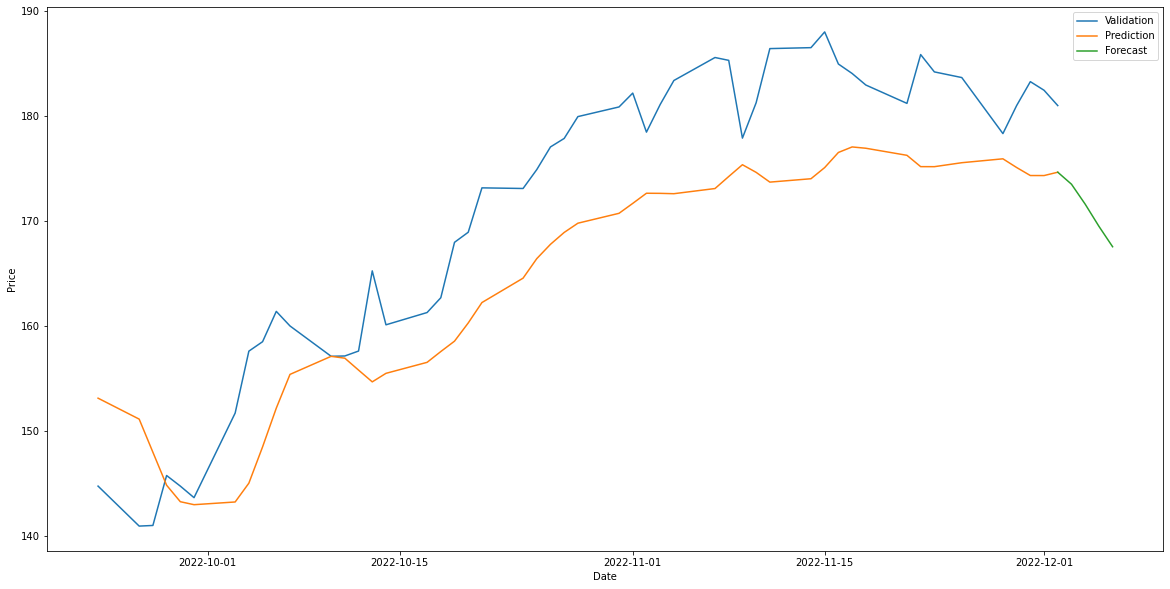

In [255]:
# Create the plot for model's predictions on the test data 
visualize = plt.figure(figsize=(20,10))
# Plot the actual price of the test data
plt.plot(stock_dateind[-50:]['Close'], label='Validation')
# Plot the prediction on test data
plt.plot(prediction_dateind[-50:]['Close'], label='Prediction')
# Plot the historicals 
plt.plot(forecast_df['Close'], label='Forecast')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()